In [1]:
#Librerías necesarias para seguir el  ejercicio. 
import json
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import itertools

In [2]:

#Variable para saber si hay más página 
next_page = True
#Página inicial
pagina = 1
#Registros que queremos por petición.
#Seleccionar un número que se adapte a sus necesidades menor a 100k.
registro = 100_000

# Rango de fecha a consultar 
periodo_inicial = '2022-01' 
periodo_final = '2023-12' 

#Endpoint que se consultará
end_point = 'carteras/creditos/clasificacion-riesgo'

#Colopar API KEY personal en la variable headers

headers={
          'Ocp-Apim-Subscription-Key': 'bdf63f2e196b46569a81b4ca88433712' ,   
          'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36',
}

#Listas que almacenará los datos
registros_list = []

#El ciclo funcionará hasta que se llegue a la última página de la petición
while next_page:
    
    #Concatenamos las variables para formar la url de la consulta
    url = f'https://apis.sb.gob.do/estadisticas/v2/{ end_point }?periodoInicial={ periodo_inicial }&periodoFinal={ periodo_final }&tipoEntidad=BM&paginas={ pagina }&registros={ registro }'

    try:
        #Hacemos la petición
        response  = requests.get(url, headers=headers) 
        #Validamos el estatus de la petición según el protocolo http.
        response.raise_for_status()
        
        #Parseamos la respuesta con los datos a Json
        datos = response.json()
        
        #Agregamos los datos a una lista conformada por dataframes de pandas
        registros_list.append(pd.DataFrame(datos))
    
        #Obtenemos los metadatos que necesitamos, los cuales decribimos más arriba en el artículo.    
        #Parseamos
        metadatos = json.loads(response.headers['x-pagination'])
        
        #Obtebemos los metadatos necesarios
        next_page = metadatos['HasNext']
        total_pages =  metadatos['TotalPages']
        total_record = metadatos["TotalRecords"]
        
        #Imprimimos la página actual y el total de página
        print('Pagina:',pagina,'/',total_pages)
        
        #Incrementamos 1 para ir a la siguiente página
        pagina +=1
        
    except requests.exceptions.HTTPError as errh:
        print("Error HTTP:", errh)
        raise errh
    except requests.exceptions.ConnectionError as errc:
        print("Error de conexión:", errc)
        raise errc
    except requests.exceptions.Timeout as errt:
        print("Error Timeout:", errt)
        raise errt
    except requests.exceptions.RequestException as err:
        print("Algo salío mal:", err)
        raise err
        
#Concatenamos la lista de dataframes en uno solo       
registros = pd.concat(registros_list, ignore_index=True)

#Vemos los primeros cinco regístros del dataframe
registros.head()

Pagina: 1 / 1


,periodo,tipoEntidad,entidad,clasificacionRiesgo,tipoCartera,cantidadPlastico,cantidadCredito,deuda,tasaPorDeuda,tasaPromedioPonderado,deudaCapital,deudaVencida,deudaVencidaDe31A90Dias,valorDesembolso,valorGarantia,valorProvisionCapitalYRendimiento
0,2022-01,BANCOS MÚLTIPLES,VIMENCA,D1,Créditos comerciales,0,7,8.636193e+07,8.535254e+08,9.883121,8.563327e+07,3.836485e+06,0.00,0.000000e+00,6.816532e+07,7.873665e+06
1,2022-01,BANCOS MÚLTIPLES,CITIBANK,A,Créditos comerciales,167,451,1.750789e+09,1.183113e+10,6.757601,1.740536e+09,0.000000e+00,0.00,2.568439e+08,9.523684e+08,1.751430e+07
2,2022-01,BANCOS MÚLTIPLES,BELLBANK,B,Créditos Hipotecarios,0,3,8.753043e+06,1.104308e+08,12.616278,8.560259e+06,1.958244e+05,195824.44,0.000000e+00,8.170599e+06,9.699980e+04
3,2022-01,BANCOS MÚLTIPLES,SCOTIABANK,D2,Créditos comerciales,13,137,1.909918e+09,1.615630e+10,8.459158,1.855236e+09,1.189926e+08,118868.31,1.030296e+08,1.735929e+09,3.308071e+08
4,2022-01,BANCOS MÚLTIPLES,BANESCO,D2,Créditos de consumo,0,1001,1.901693e+08,3.059317e+09,16.087338,1.822034e+08,1.156353e+08,527109.50,2.551211e+06,2.179640e+07,1.012873e+08


In [3]:
registros.shape

(7577, 16)

### 1- Analizar la evolución de cartera de crédito total 

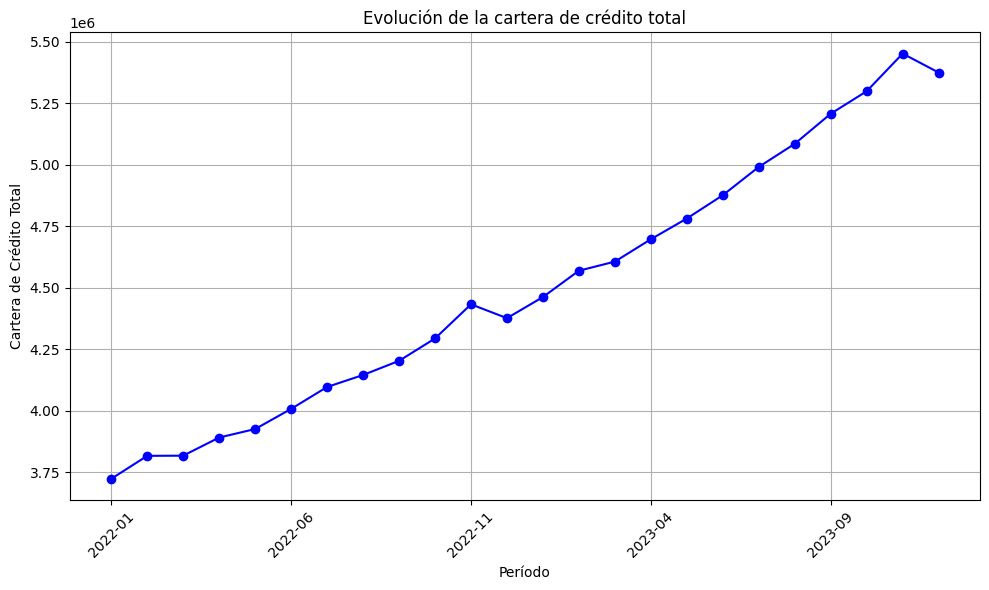

In [4]:
# Agrupar los datos por período y sumar la cantidad de crédito
cartera_credito_total = registros.groupby('periodo')['cantidadCredito'].sum()

# Visualizar la evolución de la cartera de crédito total
plt.figure(figsize=(10, 6))
cartera_credito_total.plot(kind='line', marker='o', color='b')
plt.title('Evolución de la cartera de crédito total')
plt.xlabel('Período')
plt.ylabel('Cartera de Crédito Total')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 2- Analizar la evolución de las carteras de crédito (Hipotecarios, Consumo, Tarjetas y Comerciales)

In [5]:
p = registros['tipoCartera'].unique()

print(p)


['Créditos comerciales' 'Créditos Hipotecarios' 'Créditos de consumo'
 'Tarjetas de créditos']


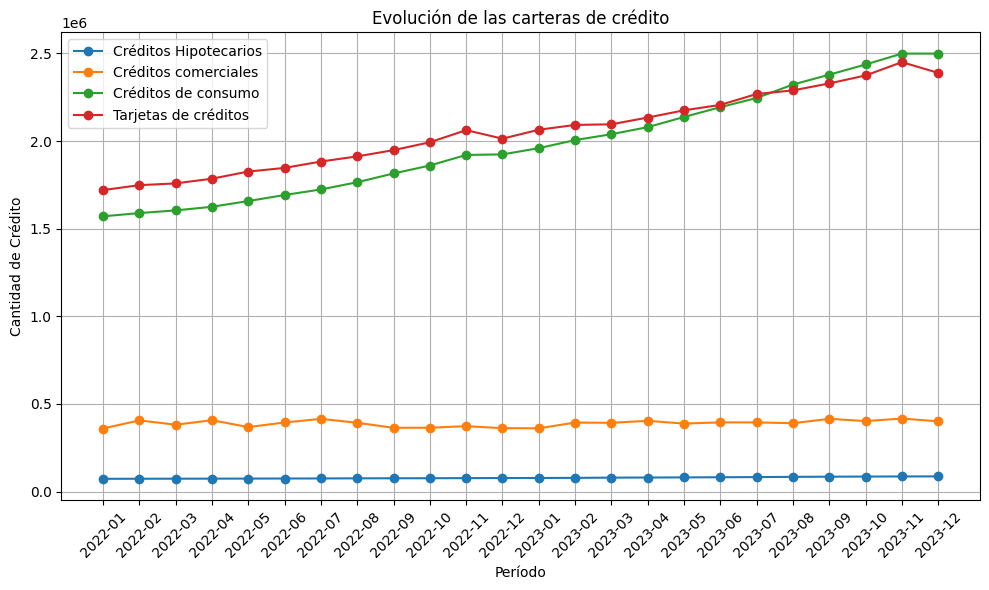

In [6]:
# se enfoca en la cantidad de crédito otorgado en cada período para todos los tipos de entidad
# Agrupar los datos por período y tipo de cartera, y sumar la cantidad de crédito
carteras_por_periodo = registros.groupby(['periodo', 'tipoCartera'])['cantidadCredito'].sum().unstack()

# Visualizar la evolución de las carteras de crédito
plt.figure(figsize=(10, 6))

# Nombres exactos de las carteras de crédito
nombres_carteras = ['Créditos Hipotecarios', 'Créditos comerciales', 'Créditos de consumo', 'Tarjetas de créditos']

# Iterar sobre las carteras de crédito y trazar el gráfico para cada una
for cartera in nombres_carteras:
    if cartera in carteras_por_periodo.columns:
        plt.plot(carteras_por_periodo.index, carteras_por_periodo[cartera], marker='o', label=cartera)

plt.title('Evolución de las carteras de crédito')
plt.xlabel('Período')
plt.ylabel('Cantidad de Crédito')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

### 3- ¿Cuántas entidades se están evaluando? 

In [7]:
p = registros['entidad'].unique()

print(p)

# 16 entidades

['VIMENCA' 'CITIBANK' 'BELLBANK' 'SCOTIABANK' 'BANESCO' 'BDI' 'ACTIVO'
 'BLH' 'SANTA CRUZ' 'LAFISE' 'POPULAR' 'BANRESERVAS' 'PROMERICA' 'BHD'
 'CARIBE' 'ADEMI' 'JMMB']


### 4- Cual entidad ha evolucionado más a nivel de monto de cartera  

In [8]:
# Agrupar los datos por entidad y período, y sumar el monto de la cartera de crédito
cartera_por_entidad = registros.groupby(['entidad', 'periodo'])['deuda'].sum().reset_index()

# Calcular la diferencia entre el último y el primer período para cada entidad
evolucion_cartera = cartera_por_entidad.pivot_table(index='entidad', columns='periodo', values='deuda')
evolucion_cartera['evolucion'] = evolucion_cartera.iloc[:, -1] - evolucion_cartera.iloc[:, 0]

# Identificar la entidad con la mayor evolución
entidad_max_evolucion = evolucion_cartera['evolucion'].idxmax()
max_evolucion = evolucion_cartera.loc[entidad_max_evolucion, 'evolucion']

print("La entidad con la mayor evolución en la cartera de crédito es:", entidad_max_evolucion)
print("La evolución de la cartera de crédito para esta entidad es de:", max_evolucion)

La entidad con la mayor evolución en la cartera de crédito es: BANRESERVAS
La evolución de la cartera de crédito para esta entidad es de: 138861590499.58875


### 5- Analizar la clasificación de riesgo de las entidades sabiendo que A es menor que E

In [9]:
p = registros['clasificacionRiesgo'].unique()

print(p)

['D1' 'A' 'B' 'D2' 'C' 'E']


In [10]:
# Filtrar las entidades con clasificación de riesgo 'A'
entidades_clasificacion_A = registros[registros['clasificacionRiesgo'] == 'A']

# Contar la frecuencia de cada entidad con clasificación de riesgo 'A'
entidades_clasificacion_A_frecuencia = entidades_clasificacion_A['entidad'].value_counts()

# entidades con clasificación de riesgo 'A'
entidades_clasificacion_A = entidades_clasificacion_A_frecuencia.head(16)

print("Entidades con clasificación de riesgo 'A':")
print(entidades_clasificacion_A)

Entidades con clasificación de riesgo 'A':
entidad
POPULAR        96
VIMENCA        96
LAFISE         96
BANRESERVAS    96
PROMERICA      96
BANESCO        96
BHD            96
BDI            96
SANTA CRUZ     96
SCOTIABANK     96
CARIBE         96
BLH            96
ADEMI          96
ACTIVO         76
BELLBANK       27
CITIBANK       24
Name: count, dtype: int64


In [11]:
# Filtrar las entidades con clasificación de riesgo 'B'
entidades_clasificacion_B = registros[registros['clasificacionRiesgo'] == 'B']

# Contar la frecuencia de cada entidad con clasificación de riesgo 'B'
entidades_clasificacion_B_frecuencia = entidades_clasificacion_B['entidad'].value_counts()

# entidades con clasificación de riesgo 'B'
entidades_clasificacion_B = entidades_clasificacion_B_frecuencia.head(16)

print("Entidades con clasificación de riesgo 'B':")
print(entidades_clasificacion_B)

Entidades con clasificación de riesgo 'B':
entidad
SANTA CRUZ     96
BANESCO        96
SCOTIABANK     96
CARIBE         96
VIMENCA        96
ADEMI          96
BHD            96
BANRESERVAS    96
POPULAR        96
BLH            96
BDI            96
PROMERICA      94
LAFISE         84
ACTIVO         76
BELLBANK       26
CITIBANK       24
Name: count, dtype: int64


In [12]:
# Filtrar las entidades con clasificación de riesgo 'C'
entidades_clasificacion_C = registros[registros['clasificacionRiesgo'] == 'C']

# Contar la frecuencia de cada entidad con clasificación de riesgo 'C'
entidades_clasificacion_C_frecuencia = entidades_clasificacion_C['entidad'].value_counts()

# entidades con clasificación de riesgo 'B'
entidades_clasificacion_C = entidades_clasificacion_C_frecuencia.head(16)

print("Entidades con clasificación de riesgo 'C':")
print(entidades_clasificacion_C)

Entidades con clasificación de riesgo 'C':
entidad
POPULAR        96
SANTA CRUZ     96
BANESCO        96
SCOTIABANK     96
BHD            96
BANRESERVAS    96
BDI            95
CARIBE         95
VIMENCA        92
BLH            88
ADEMI          84
PROMERICA      76
LAFISE         74
ACTIVO         67
BELLBANK       26
CITIBANK       24
Name: count, dtype: int64


In [13]:
# Filtrar las entidades con clasificación de riesgo 'E'
entidades_clasificacion_E = registros[registros['clasificacionRiesgo'] == 'E']

# Contar la frecuencia de cada entidad con clasificación de riesgo 'E'
entidades_clasificacion_E_frecuencia = entidades_clasificacion_E['entidad'].value_counts()

# entidades con clasificación de riesgo 'E'
entidades_clasificacion_E = entidades_clasificacion_E_frecuencia.head(16)

print("Entidades con clasificación de riesgo 'E':")
print(entidades_clasificacion_E)

Entidades con clasificación de riesgo 'E':
entidad
BHD            96
SANTA CRUZ     96
BANRESERVAS    96
POPULAR        96
SCOTIABANK     88
BANESCO        87
ADEMI          76
VIMENCA        75
PROMERICA      72
CARIBE         72
BLH            64
LAFISE         58
ACTIVO         57
BDI            57
BELLBANK       18
JMMB            2
Name: count, dtype: int64


In [14]:
# Filtrar las entidades con clasificación de riesgo 'D1'
entidades_clasificacion_D1= registros[registros['clasificacionRiesgo'] == 'D1']

# Contar la frecuencia de cada entidad con clasificación de riesgo 'B'
entidades_clasificacion_D1_frecuencia = entidades_clasificacion_D1['entidad'].value_counts()

# entidades con clasificación de riesgo 'D1'
entidades_clasificacion_D1 = entidades_clasificacion_D1_frecuencia.head(16)

print("Entidades con clasificación de riesgo 'D1':")
print(entidades_clasificacion_D1)

Entidades con clasificación de riesgo 'D1':
entidad
POPULAR        96
BHD            96
SCOTIABANK     96
BANRESERVAS    96
SANTA CRUZ     95
BLH            94
LAFISE         94
BDI            93
BANESCO        90
ADEMI          84
VIMENCA        81
CARIBE         77
PROMERICA      76
ACTIVO         60
BELLBANK       27
CITIBANK        7
Name: count, dtype: int64


In [15]:
# Filtrar las entidades con clasificación de riesgo 'D2'
entidades_clasificacion_D2= registros[registros['clasificacionRiesgo'] == 'D2']

# Contar la frecuencia de cada entidad con clasificación de riesgo 'D2'
entidades_clasificacion_D2_frecuencia = entidades_clasificacion_D2['entidad'].value_counts()

# entidades con clasificación de riesgo 'D2'
entidades_clasificacion_D2 = entidades_clasificacion_D2_frecuencia.head(16)

print("Entidades con clasificación de riesgo 'D2':")
print(entidades_clasificacion_D2)

Entidades con clasificación de riesgo 'D2':
entidad
SCOTIABANK     96
POPULAR        96
BHD            96
BANRESERVAS    96
SANTA CRUZ     90
BDI            84
ADEMI          78
BANESCO        77
CARIBE         76
BLH            73
VIMENCA        73
PROMERICA      72
LAFISE         62
ACTIVO         59
CITIBANK       21
BELLBANK       11
Name: count, dtype: int64


### 6- Calcular la morosidad de cada una de las entidades (deudavencida / deuda) y hacer un análisis de su comportamiento

La morosidad es el retraso o incumplimiento en el pago de una deuda o compromiso financiero en el tiempo acordado. Esto puede aplicarse a préstamos, facturas, tarjetas de crédito u otros tipos de obligaciones financieras.

In [16]:
# Calcular la morosidad para cada entidad y período
registros['morosidad'] = registros['deudaVencida'] / registros['deuda']

# Calcular la morosidad promedio por entidad
morosidad_promedio_por_entidad = registros.groupby('entidad')['morosidad'].mean()

# Identificar las entidades con la morosidad más alta y más baja
entidad_mayor_morosidad = morosidad_promedio_por_entidad.idxmax()
mayor_morosidad = morosidad_promedio_por_entidad.max()

entidad_menor_morosidad = morosidad_promedio_por_entidad.idxmin()
menor_morosidad = morosidad_promedio_por_entidad.min()

print("Entidad con la morosidad más alta:", entidad_mayor_morosidad)
print("Morosidad más alta:", mayor_morosidad)

print("Entidad con la morosidad más baja:", entidad_menor_morosidad)
print("Morosidad más baja:", menor_morosidad)

# Puedes seguir con otros análisis según tus necesidades

Entidad con la morosidad más alta: ACTIVO
Morosidad más alta: 0.455943740729921
Entidad con la morosidad más baja: CITIBANK
Morosidad más baja: 0.008655762072572324


### 7- Calcular la morosidad de cada una de las entidades por tipo de carteras (Hipotecarios, Consumo, Tarjetas y Comerciales) y hacer un análisis de su comportamiento 

In [17]:
p = registros['tipoCartera'].unique()

print(p)

['Créditos comerciales' 'Créditos Hipotecarios' 'Créditos de consumo'
 'Tarjetas de créditos']


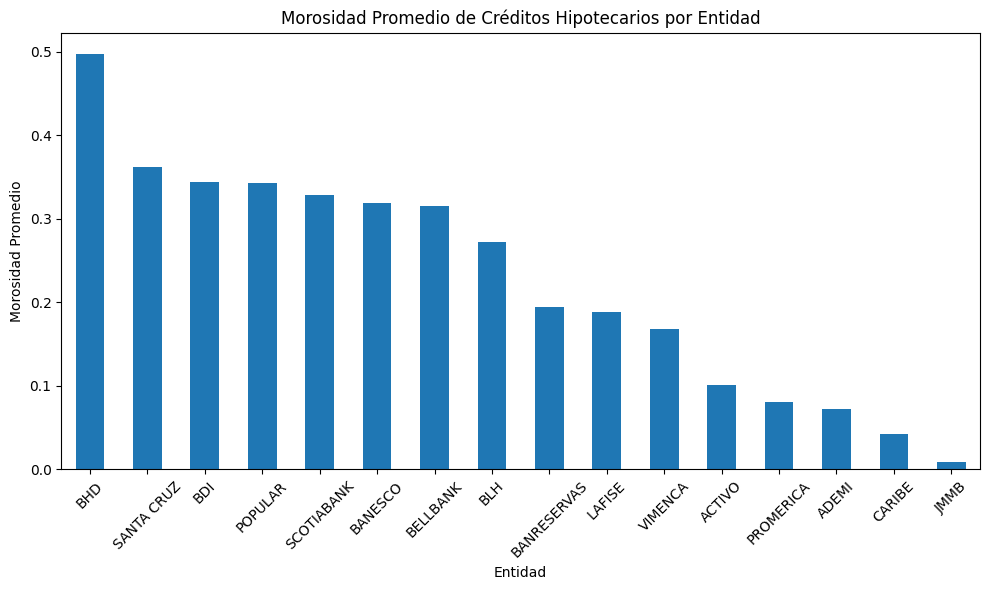

In [18]:
# Filtrar los datos para incluir solo los créditos hipotecarios
creditos_hipotecarios = registros[registros['tipoCartera'] == 'Créditos Hipotecarios']

# Calcular la morosidad por entidad para los créditos hipotecarios
morosidad_creditos_hipotecarios = creditos_hipotecarios.groupby('entidad')['morosidad'].mean()

# Ordenar las entidades por morosidad promedio
morosidad_creditos_hipotecarios = morosidad_creditos_hipotecarios.sort_values(ascending=False)

# Visualizar la morosidad promedio de los créditos hipotecarios por entidad en un gráfico de barras
plt.figure(figsize=(10, 6))
morosidad_creditos_hipotecarios.plot(kind='bar')
plt.title('Morosidad Promedio de Créditos Hipotecarios por Entidad')
plt.xlabel('Entidad')
plt.ylabel('Morosidad Promedio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

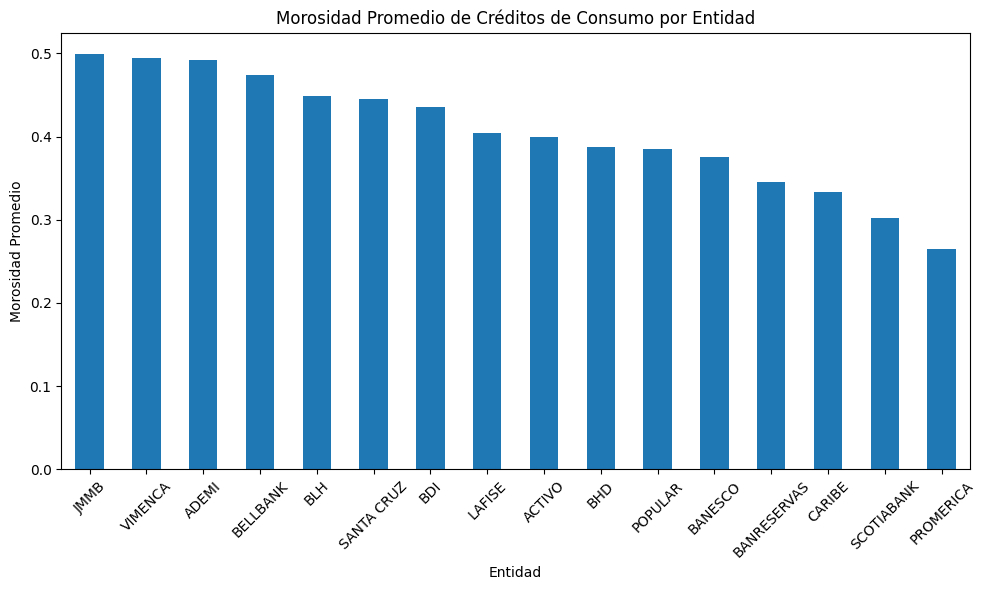

In [19]:
# Filtrar los datos para incluir solo los créditos de consumo
creditos_consumo = registros[registros['tipoCartera'] == 'Créditos de consumo']

# Calcular la morosidad por entidad para los créditos de consumo
morosidad_creditos_consumo = creditos_consumo.groupby('entidad')['morosidad'].mean()

# Ordenar las entidades por morosidad promedio
morosidad_creditos_consumo = morosidad_creditos_consumo.sort_values(ascending=False)

# Visualizar la morosidad promedio de los créditos de consumo por entidad en un gráfico de barras
plt.figure(figsize=(10, 6))
morosidad_creditos_consumo.plot(kind='bar')
plt.title('Morosidad Promedio de Créditos de Consumo por Entidad')
plt.xlabel('Entidad')
plt.ylabel('Morosidad Promedio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

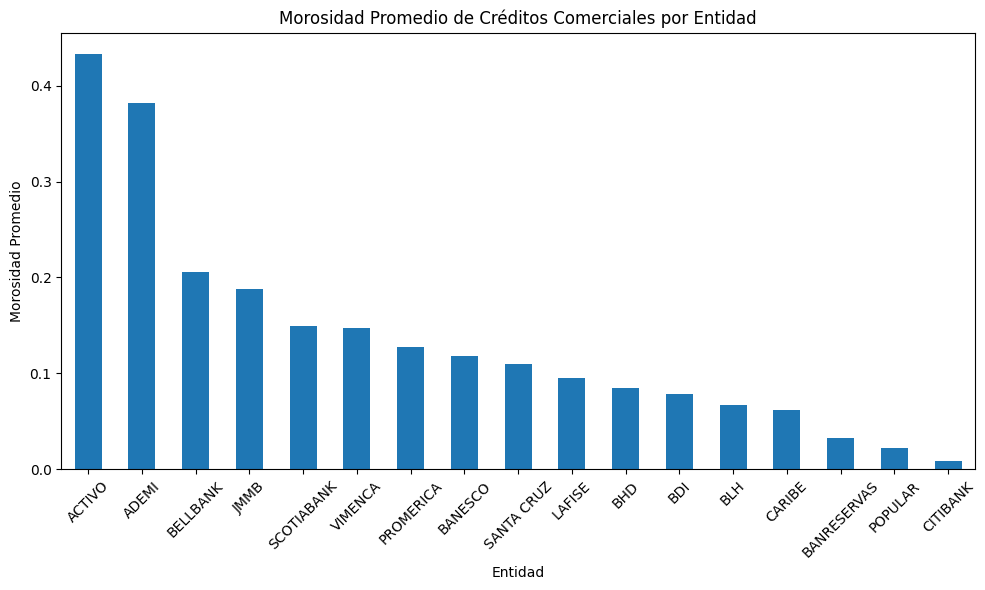

In [20]:
# Filtrar los datos para incluir solo los créditos comerciales
creditos_comerciales = registros[registros['tipoCartera'] == 'Créditos comerciales']

# Calcular la morosidad por entidad para los créditos comerciales
morosidad_creditos_comerciales = creditos_comerciales.groupby('entidad')['morosidad'].mean()

# Ordenar las entidades por morosidad promedio
morosidad_creditos_comerciales = morosidad_creditos_comerciales.sort_values(ascending=False)

# Visualizar la morosidad promedio de los créditos comerciales por entidad en un gráfico de barras
plt.figure(figsize=(10, 6))
morosidad_creditos_comerciales.plot(kind='bar')
plt.title('Morosidad Promedio de Créditos Comerciales por Entidad')
plt.xlabel('Entidad')
plt.ylabel('Morosidad Promedio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

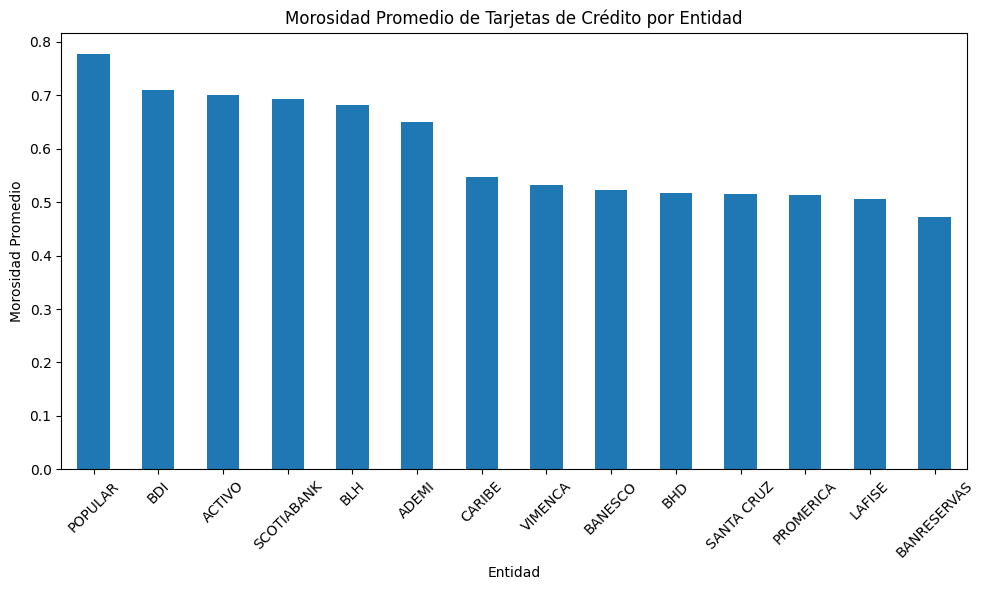

In [21]:
# Filtrar los datos para incluir solo las tarjetas de crédito
tarjetas_credito = registros[registros['tipoCartera'] == 'Tarjetas de créditos']

# Calcular la morosidad por entidad para las tarjetas de crédito
morosidad_tarjetas_credito = tarjetas_credito.groupby('entidad')['morosidad'].mean()

# Ordenar las entidades por morosidad promedio
morosidad_tarjetas_credito = morosidad_tarjetas_credito.sort_values(ascending=False)

# Visualizar la morosidad promedio de las tarjetas de crédito por entidad en un gráfico de barras
plt.figure(figsize=(10, 6))
morosidad_tarjetas_credito.plot(kind='bar')
plt.title('Morosidad Promedio de Tarjetas de Crédito por Entidad')
plt.xlabel('Entidad')
plt.ylabel('Morosidad Promedio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 8- A nivel de monto de cartera menciona el ranking 5 de entidades

In [22]:
# Calcular el monto total de cartera por entidad
monto_cartera_por_entidad = registros.groupby('entidad')['deuda'].sum()

# Ordenar las entidades por monto de cartera (de manera descendente)
monto_cartera_por_entidad_ordenado = monto_cartera_por_entidad.sort_values(ascending=False)

# Seleccionar las cinco primeras entidades
top_5_entidades_monto_cartera = monto_cartera_por_entidad_ordenado.head(5)

print("Top 5 de entidades por monto de cartera:")
print(top_5_entidades_monto_cartera)

Top 5 de entidades por monto de cartera:
entidad
BANRESERVAS    1.063752e+13
POPULAR        1.020639e+13
BHD            6.435621e+12
SCOTIABANK     2.274198e+12
SANTA CRUZ     1.311748e+12
Name: deuda, dtype: float64


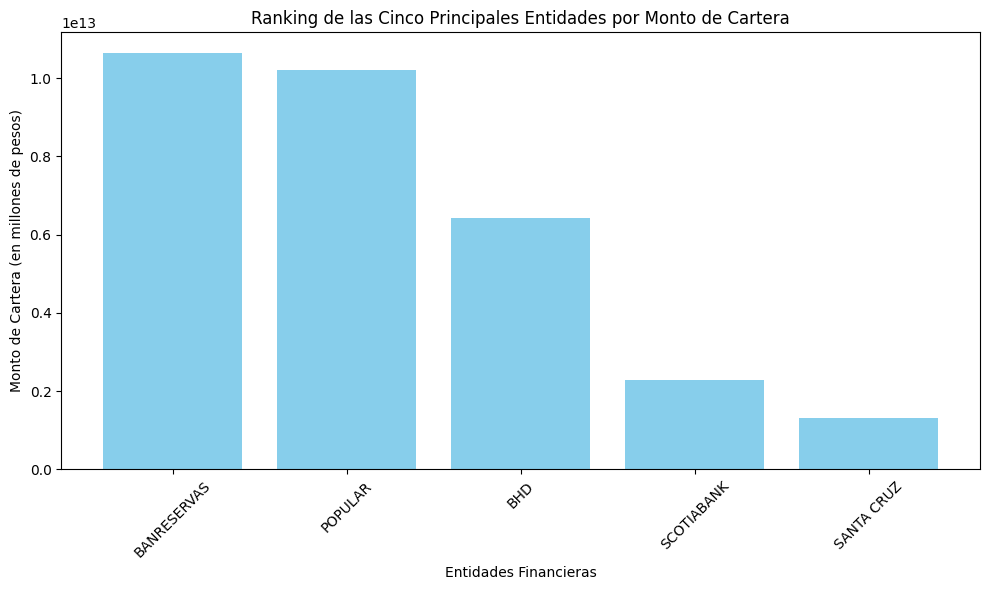

In [23]:
# Datos de las entidades y sus montos de cartera
entidades = ['BANRESERVAS', 'POPULAR', 'BHD', 'SCOTIABANK', 'SANTA CRUZ']
montos_cartera = [10637520000000, 10206390000000, 6435621000000, 2274198000000, 1311748000000]

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(entidades, montos_cartera, color='skyblue')

# Añadir etiquetas y título
plt.xlabel('Entidades Financieras')
plt.ylabel('Monto de Cartera (en millones de pesos)')
plt.title('Ranking de las Cinco Principales Entidades por Monto de Cartera')

# Rotar etiquetas del eje x para mejor visualización
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

## 9-  Tabulación de datos estadísticos  
## a. Tomar las columnas de Entidad y cantidad de créditos 
## b. Crear el rango o recorrido de la cantidad de créditos 
## c. Calcular el número de intervalos o clases 
## d. Calcular la amplitud del intervalo de clase 
## e. Calcular los límites del intervalo 
## f. Calcular la tabulación 
## g. Calcular la marca de la clase o punto medio 
## h. Presentar la tabla de frecuencia  

In [24]:
# (A) Tomar las columnas de Entidad y cantidad de créditos
datos = registros[['entidad', 'cantidadCredito']]

# Visualizar los primeros registros para asegurarnos de que los datos se hayan seleccionado correctamente
print(datos.head(11))

       entidad  cantidadCredito
0      VIMENCA                7
1     CITIBANK              451
2     BELLBANK                3
3   SCOTIABANK              137
4      BANESCO             1001
5          BDI               19
6       ACTIVO               80
7          BLH                5
8   SANTA CRUZ             6263
9       LAFISE              467
10     POPULAR              146


In [25]:
# (B) Calcular el rango o recorrido de la cantidad de créditos
rango_cantidad_credito = datos['cantidadCredito'].max() - datos['cantidadCredito'].min()

print("El rango de la cantidad de créditos es:", rango_cantidad_credito)

El rango de la cantidad de créditos es: 985236


In [26]:
# (C) Calcular el número de intervalos o clases (usando la regla de Sturges)
numero_intervalos = int(1 + 3.322 * np.log10(len(datos)))

print("El número de intervalos o clases es:", numero_intervalos)

El número de intervalos o clases es: 13


In [27]:
# (D) Calcular la amplitud del intervalo de clase
amplitud_intervalo = rango_cantidad_credito / numero_intervalos

print("La amplitud del intervalo de clase es:", amplitud_intervalo)


La amplitud del intervalo de clase es: 75787.38461538461


In [28]:
# (E) Calcular los límites del intervalo
limites_inferiores = [datos['cantidadCredito'].min() + i * amplitud_intervalo for i in range(numero_intervalos)]
limites_superiores = [limite + amplitud_intervalo for limite in limites_inferiores[:-1]] + [datos['cantidadCredito'].max()]

# Imprimir los límites del intervalo
print("Límites Inferiores:", limites_inferiores)
print("Límites Superiores:", limites_superiores)


Límites Inferiores: [1.0, 75788.38461538461, 151575.76923076922, 227363.15384615381, 303150.53846153844, 378937.92307692306, 454725.30769230763, 530512.6923076923, 606300.0769230769, 682087.4615384615, 757874.8461538461, 833662.2307692308, 909449.6153846153]
Límites Superiores: [75788.38461538461, 151575.76923076922, 227363.15384615381, 303150.53846153844, 378937.92307692306, 454725.3076923077, 530512.6923076923, 606300.0769230769, 682087.4615384615, 757874.8461538461, 833662.2307692308, 909449.6153846154, 985237]


In [29]:
# (F) Calcular la marca de la clase o punto medio
marca_clase = [(lim_inf + lim_sup) / 2 for lim_inf, lim_sup in zip(limites_inferiores, limites_superiores)]

# Imprimir la marca de la clase
print("Marca de Clase:")
print(marca_clase)


Marca de Clase:
[37894.692307692305, 113682.07692307691, 189469.4615384615, 265256.8461538461, 341044.23076923075, 416831.6153846154, 492618.99999999994, 568406.3846153845, 644193.7692307692, 719981.1538461538, 795768.5384615385, 871555.923076923, 947343.3076923076]


In [30]:
# (G) Crear la tabla de frecuencia
# Tomar las columnas de Entidad y cantidad de créditos
entidad_cantidad_creditos = registros[['entidad', 'cantidadCredito']]

# Agrupar los datos por entidad y sumar la cantidad de créditos
cantidad_creditos_entidad = entidad_cantidad_creditos.groupby('entidad')['cantidadCredito'].sum().reset_index()

# Calcular el rango o recorrido de la cantidad de créditos
rango = cantidad_creditos_entidad['cantidadCredito'].max() - cantidad_creditos_entidad['cantidadCredito'].min()

# Calcular el número de intervalos o clases utilizando la regla de Sturges
n = len(cantidad_creditos_entidad)
k = int(1 + 3.322 * np.log10(n))

# Calcular la amplitud del intervalo de clase
amplitud = int(np.ceil(rango / k))

# Calcular los límites del intervalo
limites = [cantidad_creditos_entidad['cantidadCredito'].min() + i * amplitud for i in range(k + 1)]

# Calcular la tabulación
tabulacion = pd.cut(cantidad_creditos_entidad['cantidadCredito'], bins=limites, right=False).value_counts().reset_index()
tabulacion.columns = ['Intervalo', 'Frecuencia']

# Calcular la marca de clase o punto medio de cada intervalo
tabulacion['Marca de Clase'] = tabulacion['Intervalo'].apply(lambda x: x.mid)

# Calcular la frecuencia relativa
tabulacion['Frecuencia Relativa'] = tabulacion['Frecuencia'] / tabulacion['Frecuencia'].sum()

# Calcular la frecuencia acumulada
tabulacion['Frecuencia Acumulada'] = tabulacion['Frecuencia'].cumsum()

# Calcular la frecuencia relativa acumulada
tabulacion['Frecuencia Relativa Acumulada'] = tabulacion['Frecuencia Acumulada'] / tabulacion['Frecuencia'].sum()

# Presentar la tabla de frecuencia completa
print("Tabla de Frecuencia:")
print(tabulacion)



Tabla de Frecuencia:
              Intervalo  Frecuencia Marca de Clase  Frecuencia Relativa  \
0       [6557, 8154361)          14      4080459.0             0.823529   
1  [16302165, 24449969)           2     20376067.0             0.117647   
2  [32597773, 40745577)           1     36671675.0             0.058824   
3   [8154361, 16302165)           0     12228263.0             0.000000   
4  [24449969, 32597773)           0     28523871.0             0.000000   

   Frecuencia Acumulada  Frecuencia Relativa Acumulada  
0                    14                       0.823529  
1                    16                       0.941176  
2                    17                       1.000000  
3                    17                       1.000000  
4                    17                       1.000000  


In [31]:
from tabulate import tabulate

# Datos de ejemplo
datos = [
    {'Intervalo': '[14657, 8160841)', 'Frecuencia': 13, 'Marca de Clase': 4087749.0, 'Frecuencia Relativa': 0.8125, 'Frecuencia Acumulada': 13, 'Frecuencia Relativa Acumulada': 0.8125},
    {'Intervalo': '[16307025, 24453209)', 'Frecuencia': 2, 'Marca de Clase': 20380117.0, 'Frecuencia Relativa': 0.1250, 'Frecuencia Acumulada': 15, 'Frecuencia Relativa Acumulada': 0.9375},
    {'Intervalo': '[32599393, 40745577)', 'Frecuencia': 1, 'Marca de Clase': 36672485.0, 'Frecuencia Relativa': 0.0625, 'Frecuencia Acumulada': 16, 'Frecuencia Relativa Acumulada': 1.0000},
    {'Intervalo': '[8160841, 16307025)', 'Frecuencia': 0, 'Marca de Clase': 12233933.0, 'Frecuencia Relativa': 0.0000, 'Frecuencia Acumulada': 16, 'Frecuencia Relativa Acumulada': 1.0000},
    {'Intervalo': '[24453209, 32599393)', 'Frecuencia': 0, 'Marca de Clase': 28526301.0, 'Frecuencia Relativa': 0.0000, 'Frecuencia Acumulada': 16, 'Frecuencia Relativa Acumulada': 1.0000}
]

# Mostrar la tabla de frecuencia utilizando la función tabulate
tabla = tabulate(datos, headers='keys', tablefmt='fancy_grid')

print(tabla)



╒══════════════════════╤══════════════╤══════════════════╤═══════════════════════╤════════════════════════╤═════════════════════════════════╕
│ Intervalo            │   Frecuencia │   Marca de Clase │   Frecuencia Relativa │   Frecuencia Acumulada │   Frecuencia Relativa Acumulada │
╞══════════════════════╪══════════════╪══════════════════╪═══════════════════════╪════════════════════════╪═════════════════════════════════╡
│ [14657, 8160841)     │           13 │      4.08775e+06 │                0.8125 │                     13 │                          0.8125 │
├──────────────────────┼──────────────┼──────────────────┼───────────────────────┼────────────────────────┼─────────────────────────────────┤
│ [16307025, 24453209) │            2 │      2.03801e+07 │                0.125  │                     15 │                          0.9375 │
├──────────────────────┼──────────────┼──────────────────┼───────────────────────┼────────────────────────┼─────────────────────────────────┤
│ [325

### 10- Realizar los siguientes gráficos 
### a. Grafico de columnas mostrando la morosidad del año 2023 por mes para cada una de las entidades

In [ ]:
# Filtrar los datos para el año 2023
datos_2023 = registros[registros['periodo'].dt.year == 2023]

# Calcular la tasa de morosidad para cada entidad en cada mes
morosidad_por_entidad_y_mes = datos_2023.groupby(['entidad', datos_2023['periodo'].dt.month])['deudaVencida'].sum() / datos_2023.groupby(['entidad', datos_2023['periodo'].dt.month])['deuda'].sum()

# Reorganizar los datos para tener un DataFrame con meses como índice y entidades como columnas
morosidad_por_entidad_y_mes = morosidad_por_entidad_y_mes.unstack()

# Reindexar para asegurar que todos los meses estén representados
morosidad_por_entidad_y_mes = morosidad_por_entidad_y_mes.reindex(range(1, 13), axis=1)

# Crear el gráfico de columnas
morosidad_por_entidad_y_mes.plot(kind='bar', figsize=(12, 6))
plt.title('Morosidad del año 2023 por mes para cada entidad')
plt.xlabel('Mes')
plt.ylabel('Morosidad')
plt.xticks(range(1, 13), ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre'])
plt.legend(title='Entidad', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# La reindexación es el proceso de cambiar el índice de un objeto en pandas, ya sea un DataFrame o una Serie. Esto implica crear un nuevo objeto con los mismos datos, pero con un índice diferente. La reindexación es útil para reorganizar los datos de acuerdo a un nuevo conjunto de etiquetas de índice, llenar valores faltantes con valores específicos o eliminar filas o columnas con índices que no se desean. En resumen, la reindexación permite ajustar la estructura de los datos para satisfacer necesidades específicas de análisis o visualización.


### b. Grafico de barras mostrando el monto de deuda para el mes 12 del 2023 para cada entidad

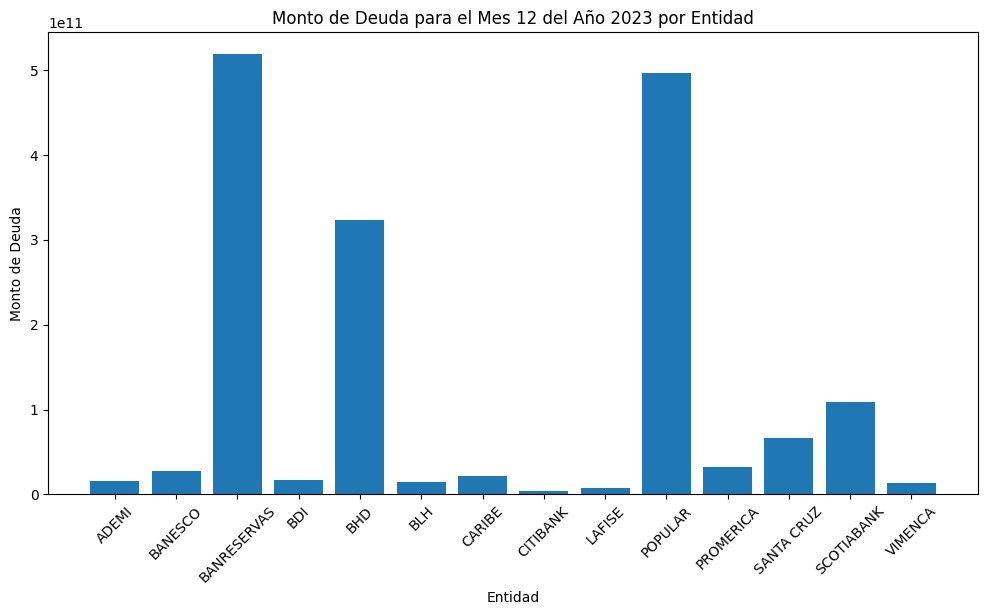

In [ ]:
# Filtrar los datos para el mes 12 del año 2023
datos_mes_12_2023 = registros[(registros['periodo'].dt.year == 2023) & (registros['periodo'].dt.month == 12)]

# Calcular el monto de deuda para cada entidad
monto_deuda_por_entidad = datos_mes_12_2023.groupby('entidad')['deuda'].sum().reset_index()

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(monto_deuda_por_entidad['entidad'], monto_deuda_por_entidad['deuda'])
plt.title('Monto de Deuda para el Mes 12 del Año 2023 por Entidad')
plt.xlabel('Entidad')
plt.ylabel('Monto de Deuda')
plt.xticks(rotation=45)
plt.show()


### c. En un grafico circular realizar la morosidad para cada tipo de producto para el año 2023 y el mes 12

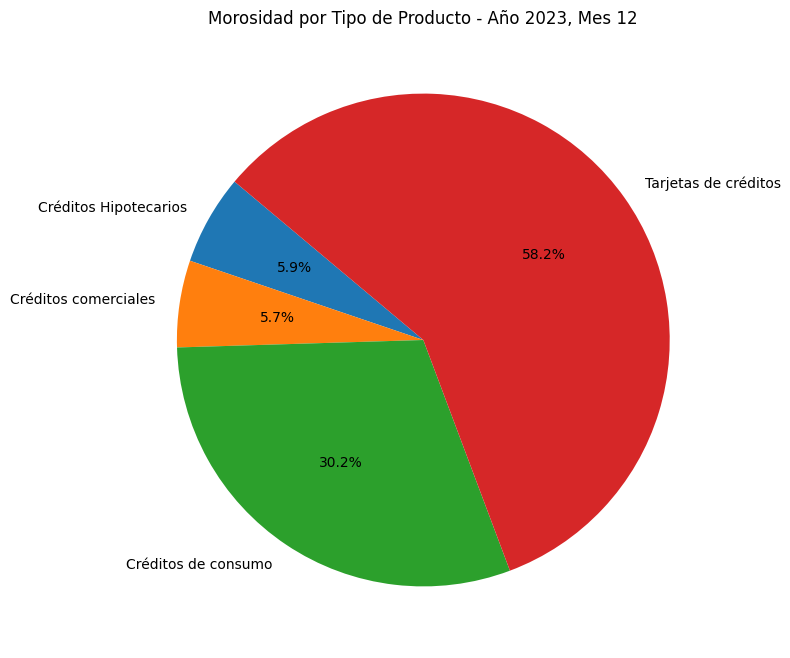

In [ ]:
# Filtrar los datos para el año 2023 y el mes 12
datos_2023_mes_12 = registros[(registros['periodo'].dt.year == 2023) & (registros['periodo'].dt.month == 12)]

# Calcular la morosidad para cada tipo de producto
morosidad_por_tipo_producto = datos_2023_mes_12.groupby('tipoCartera')['deudaVencida'].sum() / datos_2023_mes_12.groupby('tipoCartera')['deuda'].sum()

# Crear un gráfico circular
plt.figure(figsize=(8, 8))
plt.pie(morosidad_por_tipo_producto, labels=morosidad_por_tipo_producto.index, autopct='%1.1f%%', startangle=140)
plt.title('Morosidad por Tipo de Producto - Año 2023, Mes 12')
plt.show()


### d. Crear un gráfico de líneas con los balances de deuda para los años completos 2022 y 2023 para ver la evolución de las carteras

<Figure size 1200x600 with 0 Axes>

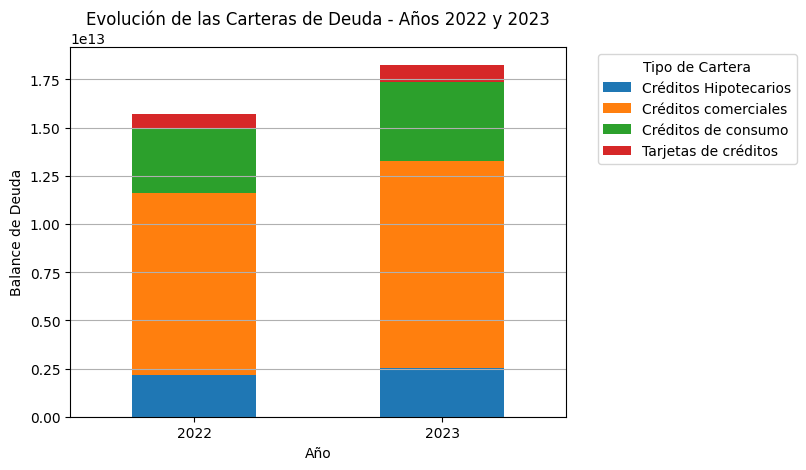

In [ ]:
# Filtrar los datos para los años 2022 y 2023
datos_2022_2023 = registros[registros['periodo'].dt.year.isin([2022, 2023])]

# Agrupar los datos por año y tipo de cartera, y calcular el balance total de deuda
balance_deuda_por_anio_cartera = datos_2022_2023.groupby([datos_2022_2023['periodo'].dt.year, 'tipoCartera'])['deuda'].sum().unstack()

# Crear un gráfico de barras
plt.figure(figsize=(12, 6))
balance_deuda_por_anio_cartera.plot(kind='bar', stacked=True)
plt.title('Evolución de las Carteras de Deuda - Años 2022 y 2023')
plt.xlabel('Año')
plt.ylabel('Balance de Deuda')
plt.xticks(rotation=0)
plt.legend(title='Tipo de Cartera', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y')
plt.show()
